In [1]:
%load_ext line_profiler
%load_ext autoreload

import numpy as np

import tensorflow as tf
import neural_tangents as nt
from neural_tangents import stax

from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random, jit

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

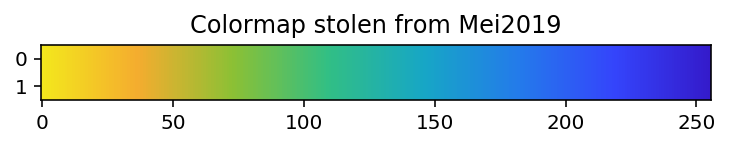

In [2]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    'Mei2019', 
    np.array([
        (243, 232, 29),
        (245, 173, 47),
        (140, 193, 53),
        (50,  191, 133),
        (23,  167, 198),
        (36,  123, 235),
        (53,  69,  252),
        (52,  27,  203)
    ])/255., 
)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig = plt.figure(figsize=(6,.5))
img = plt.imshow(gradient, aspect='auto', cmap=cmap)
title = plt.title('Colormap stolen from Mei2019')

Prepare data

In [3]:
from scipy.special import expit as sigmoid

In [4]:
P = 2000 #train
P_test = 1000

In [611]:
d = 2*P

x = np.random.randn(P+P_test,d)
x = np.sqrt(d) * x / np.linalg.norm(x, axis=1, keepdims=True)

a0 = np.random.randn(d)
a0 = np.sqrt(d) * a0 / np.linalg.norm(a0)

L = x @ a0 / np.sqrt(d)

sigma = .1
y = np.random.binomial(1, sigmoid(L/sigma))*2-1 #logistic model

X_train, X_test = x[:P], x[P:]
y_train, y_test = y[:P], y[P:]

(array([  1.,  12., 100., 358., 801., 937., 577., 175.,  34.,   5.]),
 array([-4.27455296, -3.45577109, -2.63698923, -1.81820737, -0.9994255 ,
        -0.18064364,  0.63813823,  1.45692009,  2.27570195,  3.09448382,
         3.91326568]),
 <a list of 10 Patch objects>)

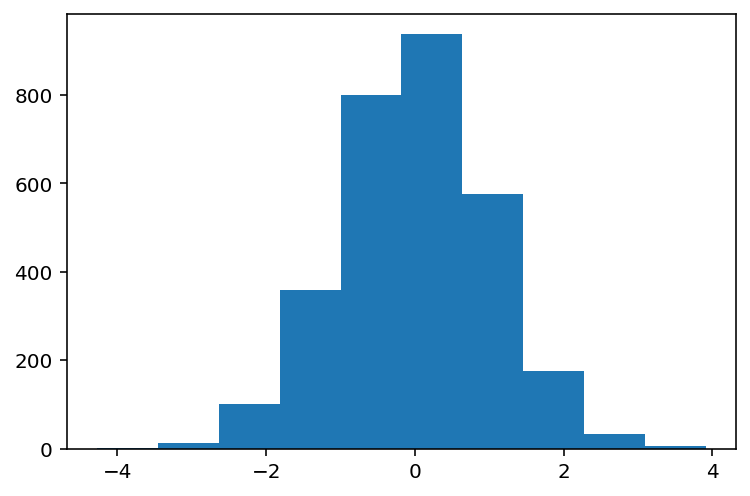

In [612]:
plt.hist(L)

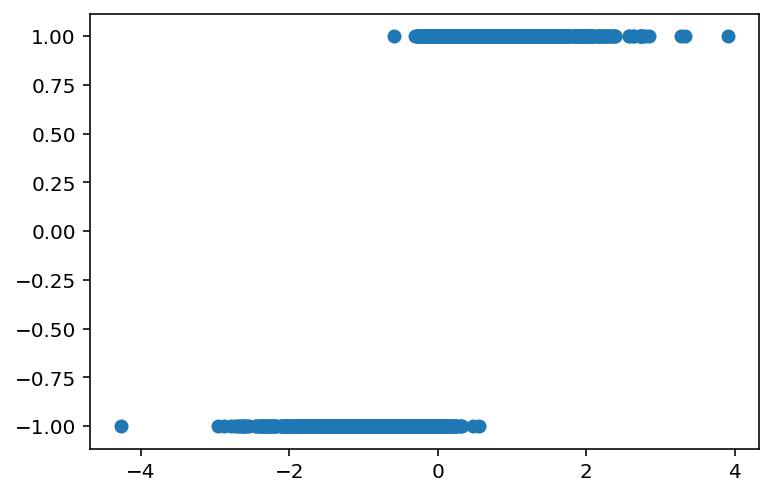

In [613]:
plt.scatter(L[:P], y_train)

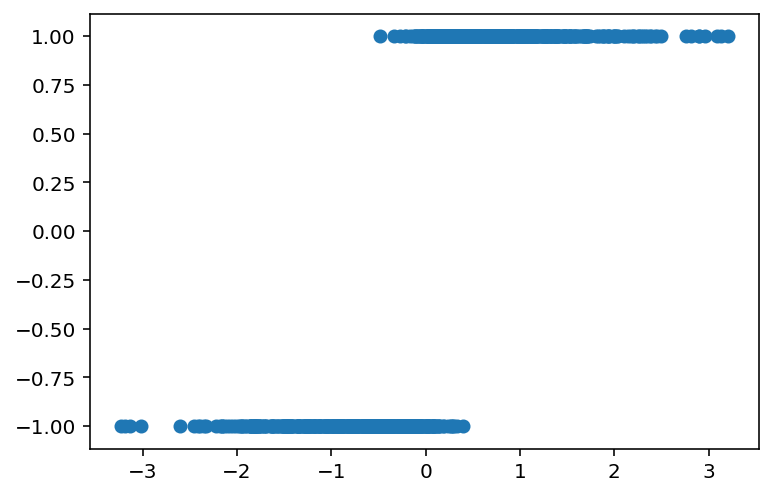

In [614]:
plt.scatter(L[P:], y_test)

In [615]:
"""
    Minimizing squared hinge loss with small regularization on the weights. 
    This gives us an L2-regularized L2-loss SVM:
        https://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf#equation.A.2
"""
import liblinear
import liblinearutil
import os

lamb = 1e-3
C = 1/(P*lamb)

#Primal (-s 2) is faster in our case
model = liblinearutil.train(y_train.reshape(-1), np.array(X_train), f'-s 2 -n {os.cpu_count()} -c {C}')

In [616]:
p_label, p_acc, p_val = liblinearutil.predict(y_train.reshape(-1), np.array(X_train), model, '-q')

Text(0.5, 1.0, 'Train: 100% accuracy')

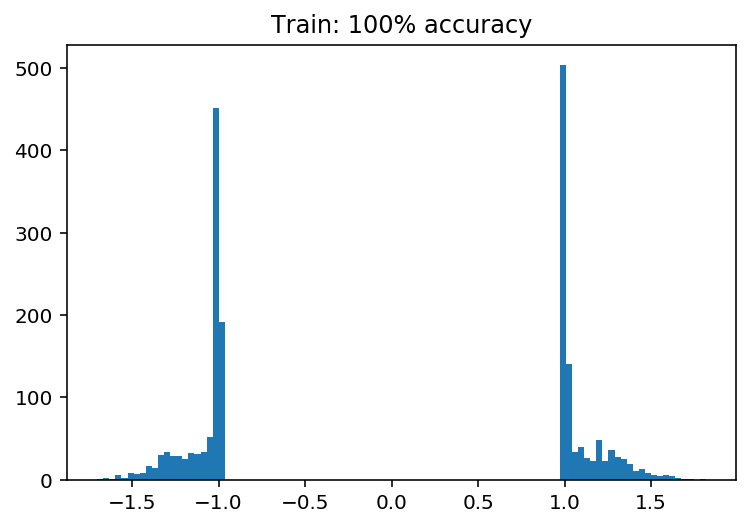

In [617]:
hist = plt.hist(np.ravel(p_val), bins = 100)
plt.title(f'Train: {p_acc[0]:.0f}% accuracy')

In [618]:
p_label, p_acc, p_val = liblinearutil.predict(y_test.reshape(-1), np.array(X_test), model, '-q')

Text(0.5, 1.0, 'Test: 70% accuracy')

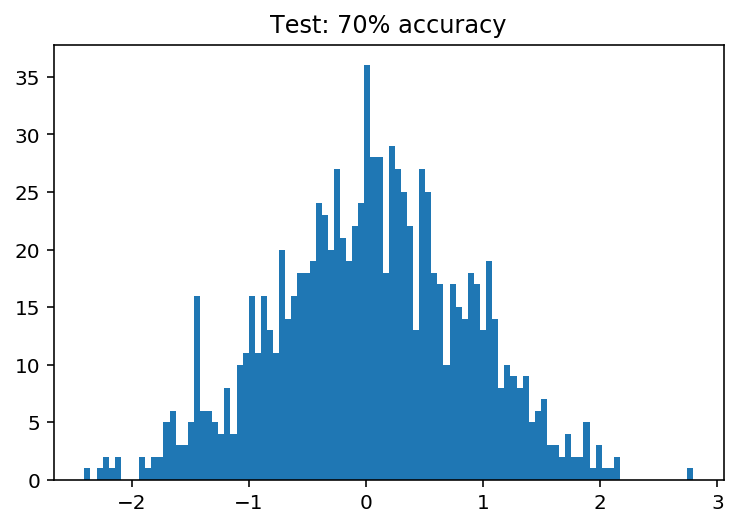

In [619]:
hist = plt.hist(np.ravel(p_val), bins = 100)
plt.title(f'Test: {p_acc[0]:.0f}% accuracy')

## Train loop

In [626]:
from tqdm import notebook as tqdm

In [627]:
results = []

for sqrt_d in tqdm.tqdm(np.arange(np.sqrt(d), 1, -1)):
    di = int(sqrt_d**2) #Quadratic, as if we were changing h in the NTK case
    
    x = np.random.randn(P+P_test, di)
    x = np.sqrt(di) * x / np.linalg.norm(x, axis=1, keepdims=True)

    a0 = np.random.randn(di)
    a0 = np.sqrt(di) * a0 / np.linalg.norm(a0)

    L = x @ a0 / np.sqrt(di)

    sigma = .1
    y = np.random.binomial(1, sigmoid(L/sigma))*2-1 #logistic model

    X_train, X_test = x[:P], x[P:]
    y_train, y_test = y[:P], y[P:]
    
    for lamb in np.logspace(0,-8, 5):
        C = 1/(P*lamb)
        model = liblinearutil.train(y_train.reshape(-1), np.array(X_train), f'-s 2 -n {os.cpu_count()} -c {C}')

        train_p_label, train_p_acc, train_p_val = liblinearutil.predict(y_train.reshape(-1), np.array(X_train), model, '-q')
        test_p_label, test_p_acc, test_p_val = liblinearutil.predict(y_test.reshape(-1), np.array(X_test), model, '-q')
        
        result = {
            'sigma': sigma,
            'd': di,
            'P': P,
            'lambda': lamb,
            'y_train': y_train.reshape(-1),
            'y_train_hat': np.array(train_p_val).reshape(-1),
            'y_test': y_test.reshape(-1),
            'y_test_hat': np.array(test_p_val).reshape(-1)
        }
        
        results.append(result)

In [3]:
import pandas as pd

In [42]:
result_df = pd.read_json(open('results/spherical_gaussian_cov_hinge.json', 'r'))
for column in result_df.columns:
    result_df[column] = result_df[column].apply(lambda x: np.array(x) if isinstance(x, list) else x)

In [43]:
# result_df = pd.DataFrame(results)
# result_df.to_json(open('results/spherical_gaussian_cov_hinge.json', 'w'))

In [44]:
force = lambda y,f: 1 - y*f
loss = lambda y,f: np.mean(np.maximum(0, force(y,f))**2)
N_del = lambda y,f: np.sum(force(y,f) >= 0)

In [45]:
result_df['d/P'] = result_df['d']/result_df['P']
result_df['P/d'] = result_df['P']/result_df['d']

result_df['test_loss'] = np.vectorize(loss)(result_df.y_test, result_df.y_test_hat)
result_df['train_loss'] = np.vectorize(loss)(result_df.y_train, result_df.y_train_hat)
result_df['d_del'] = np.vectorize(N_del)(result_df.y_train, result_df.y_train_hat)
result_df['d_del/P'] = result_df['d_del']/result_df['P']
result_df['d_del/d'] = result_df['d_del']/result_df['d']

Text(0.5, 1.0, 'Hinge loss on spherical gaussian data with linear-logistic labels')

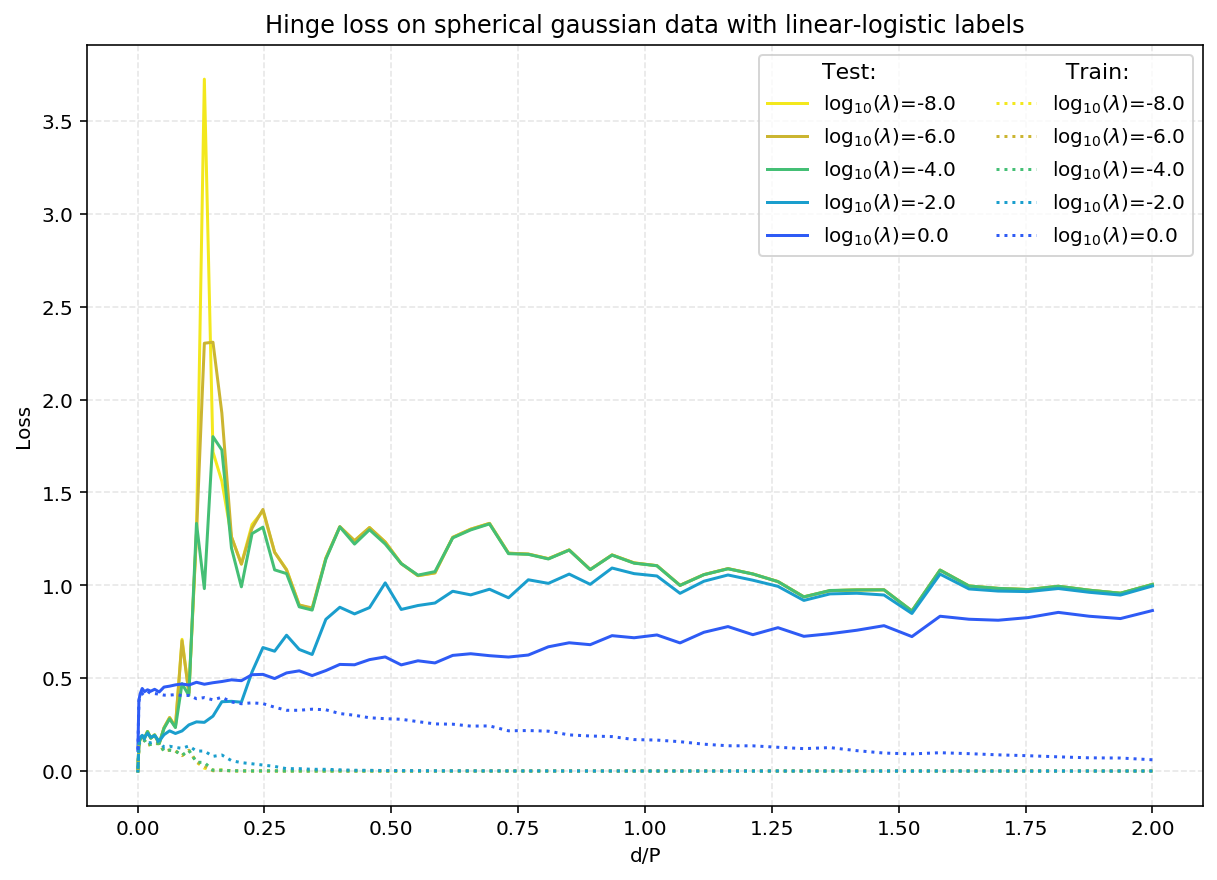

In [46]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('d/P', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)))

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('d/P', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), ls=':')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')

# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

Text(0.5, 1.0, 'Hinge loss on spherical gaussian data with linear-logistic labels')

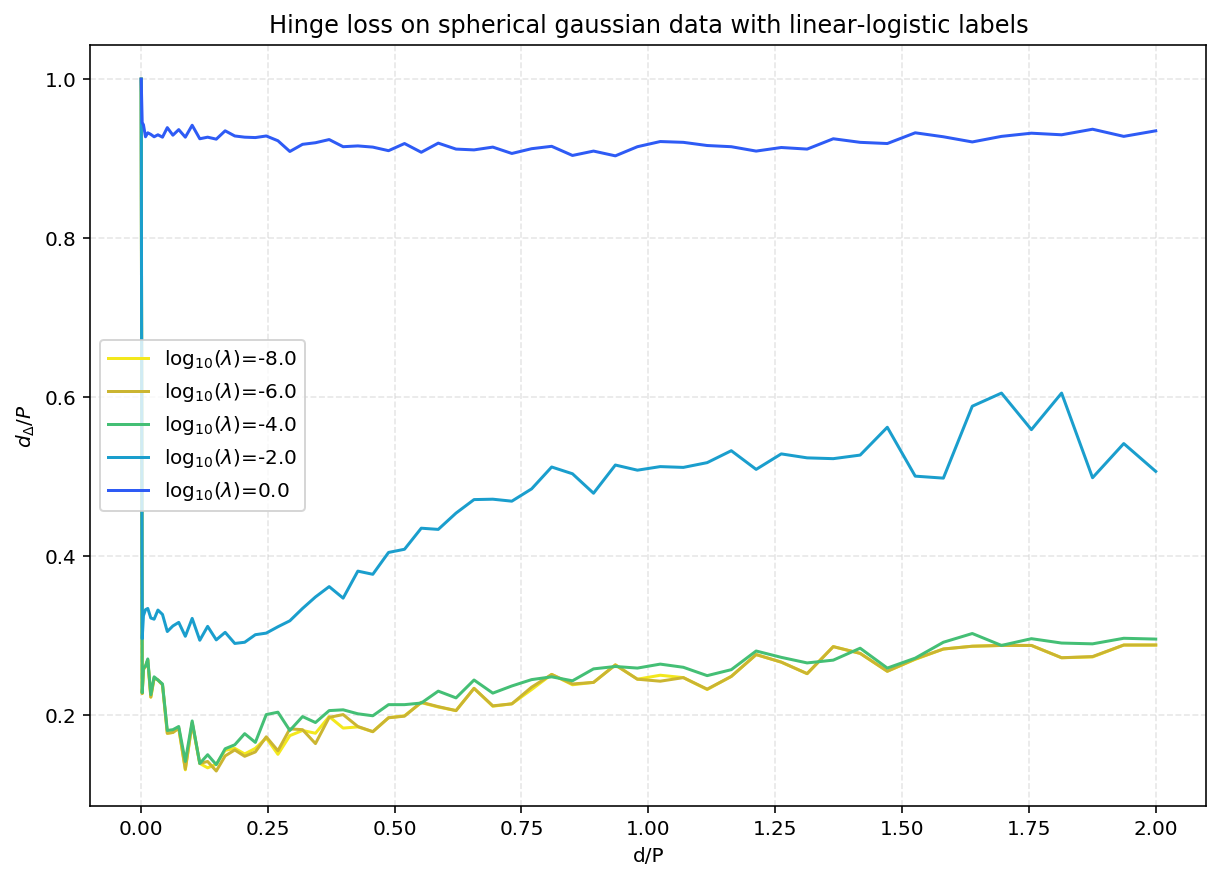

In [47]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('d/P', 'd_del/P', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)))

ax.set_ylabel(r'$d_{\Delta}/P$')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')


(0, 2)

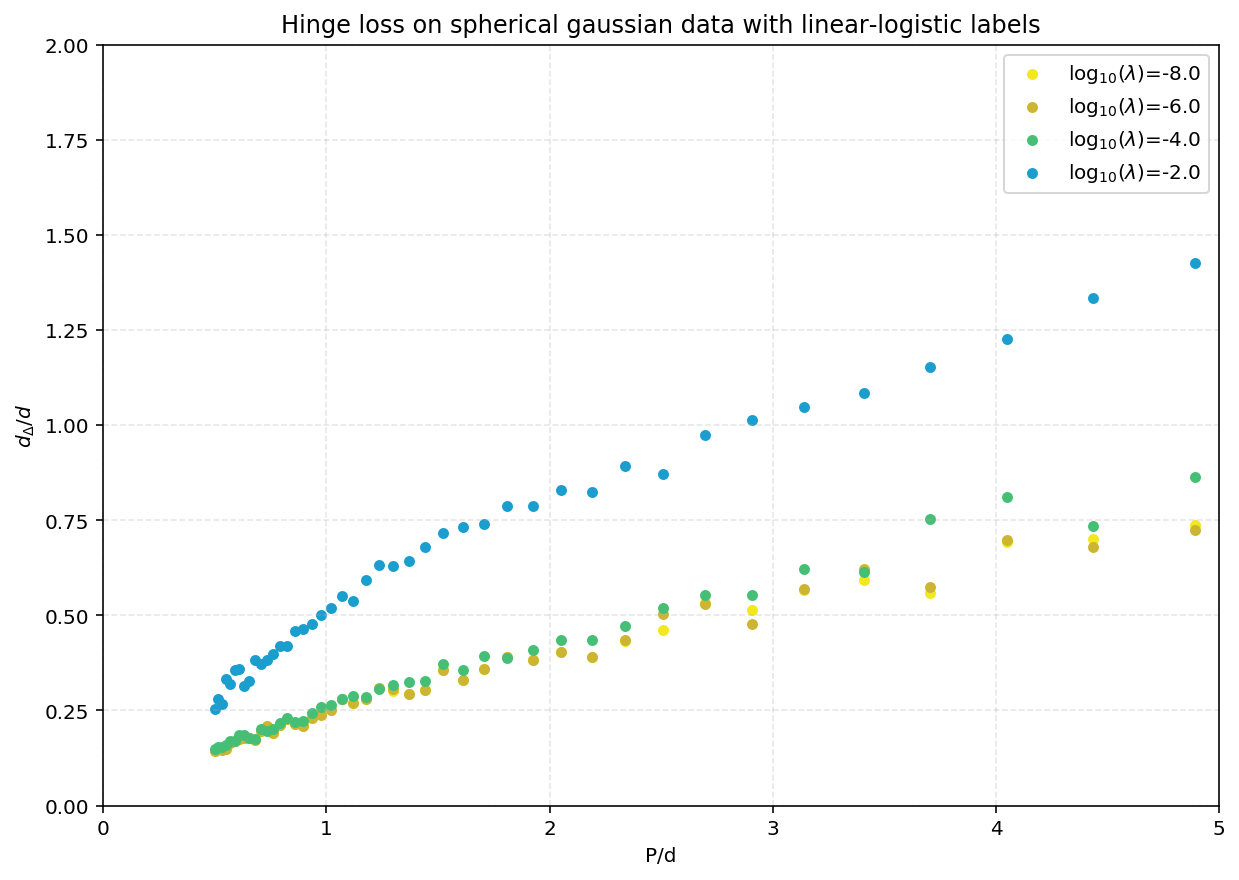

In [48]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    if lamb < 1:
        df.iloc[:-1].plot('P/d', 'd_del/d', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

ax.set_ylabel(r'$d_{\Delta}/d$')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
ax.set_xlim(0,5)
ax.set_ylim(0,2)
# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

(0, 10)

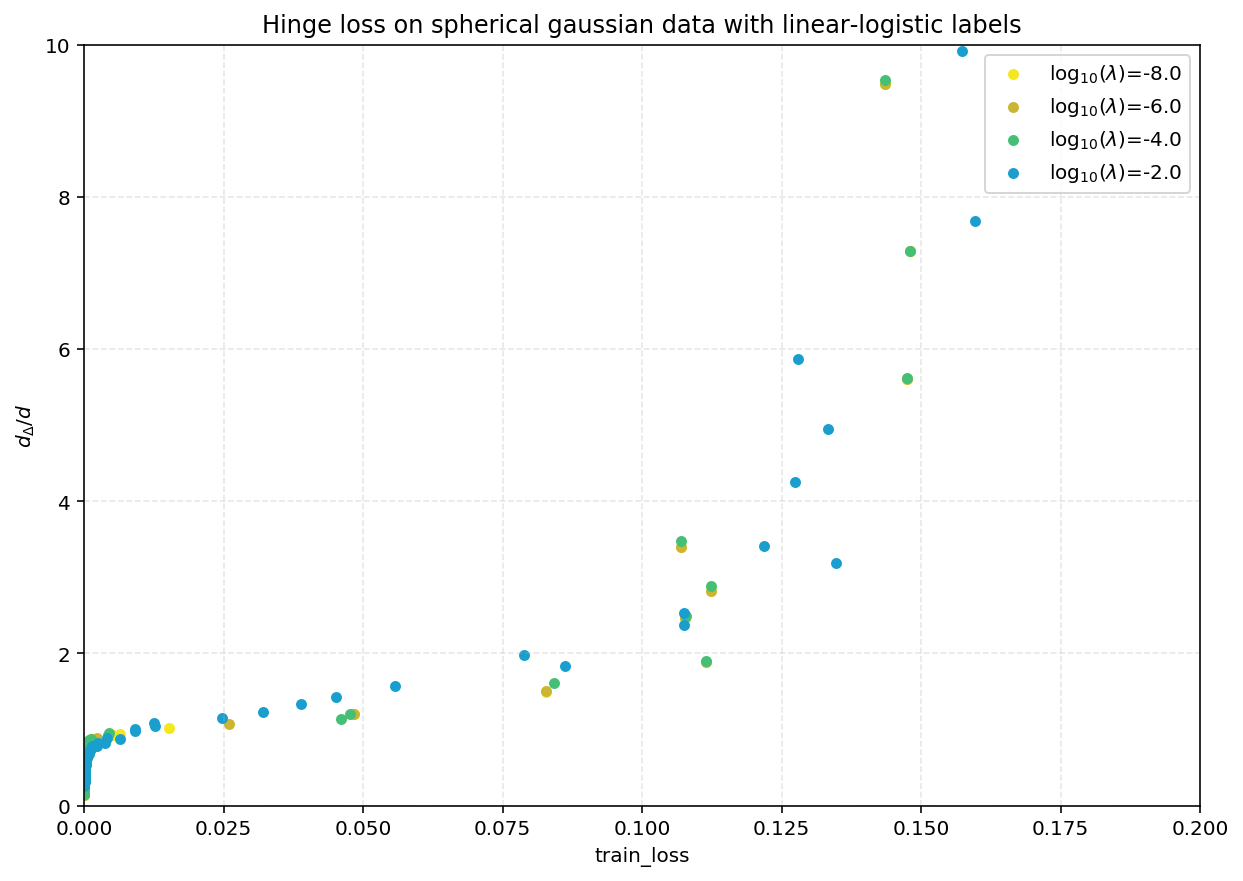

In [301]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    if lamb < 1:
        df.iloc[:-1].plot('train_loss', 'd_del/d', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

ax.set_ylabel(r'$d_{\Delta}/$')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
ax.set_xlim(0,.2)
ax.set_ylim(0,10)
# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

(0, 2)

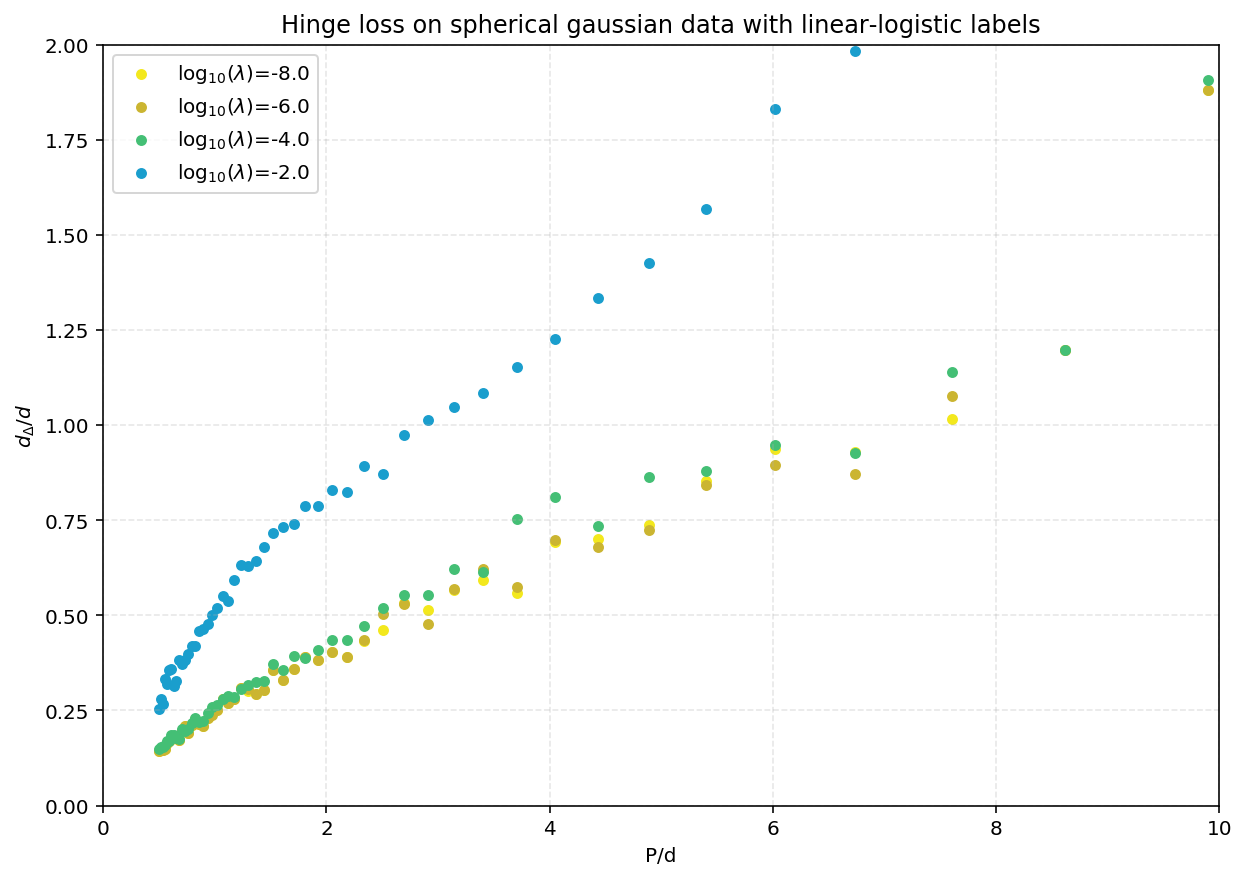

In [310]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    if lamb < 1:
        df.iloc[:-1].plot('P/d', 'd_del/d', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

ax.set_ylabel(r'$d_{\Delta}/d$')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
ax.set_xlim(0,10)
ax.set_ylim(0,2)
# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

(0, 10)

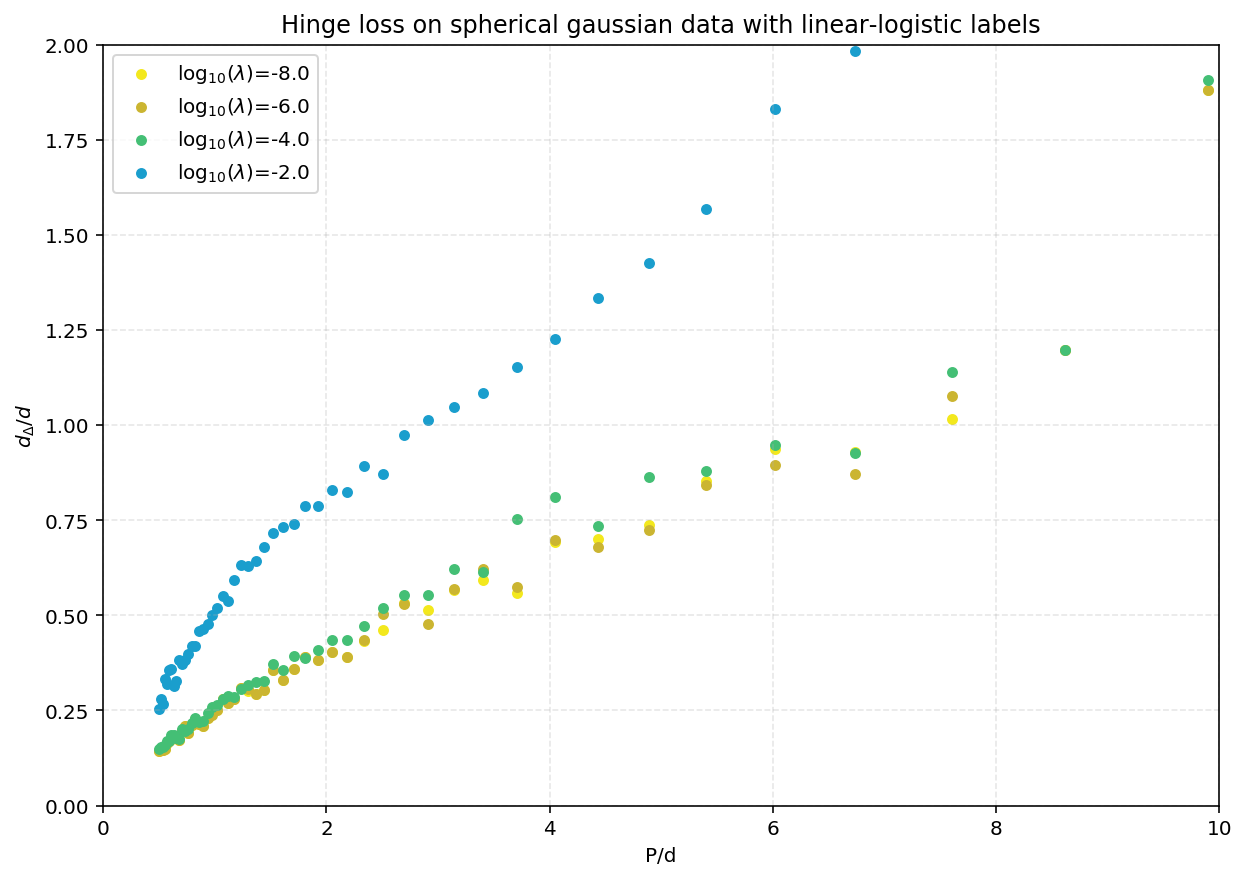

In [333]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    if lamb < 1:
        df.iloc[:-1].plot('P/d', 'd_del/d', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

ax.set_ylabel(r'$d_{\Delta}/d$')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
plt.ylim(0,2)
plt.xlim(0,10)

# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

(0, 2)

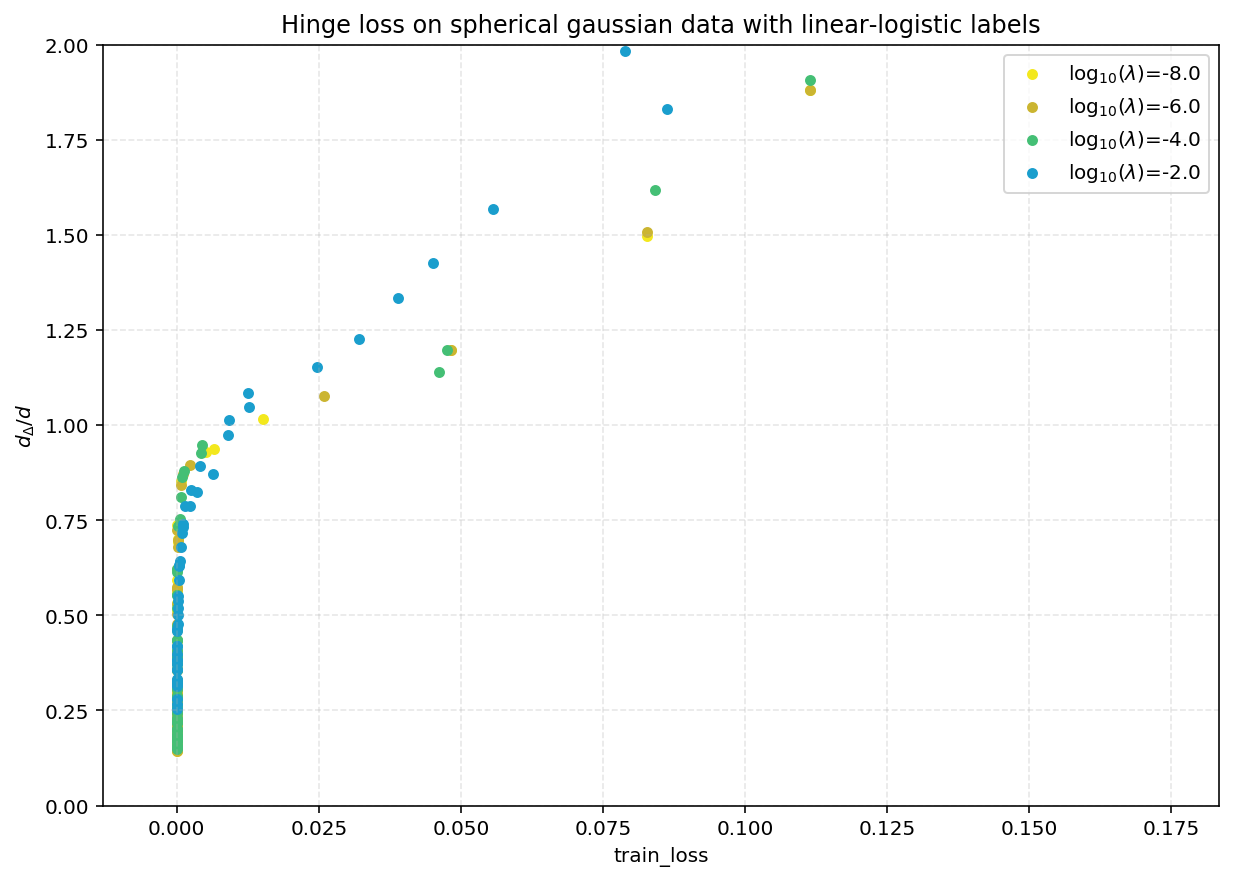

In [275]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    if lamb < 1:
        df.iloc[:-1].plot('train_loss', 'd_del/d', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

ax.set_ylabel(r'$d_{\Delta}/d$')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
plt.ylim(0,2)
# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

(0, 2)

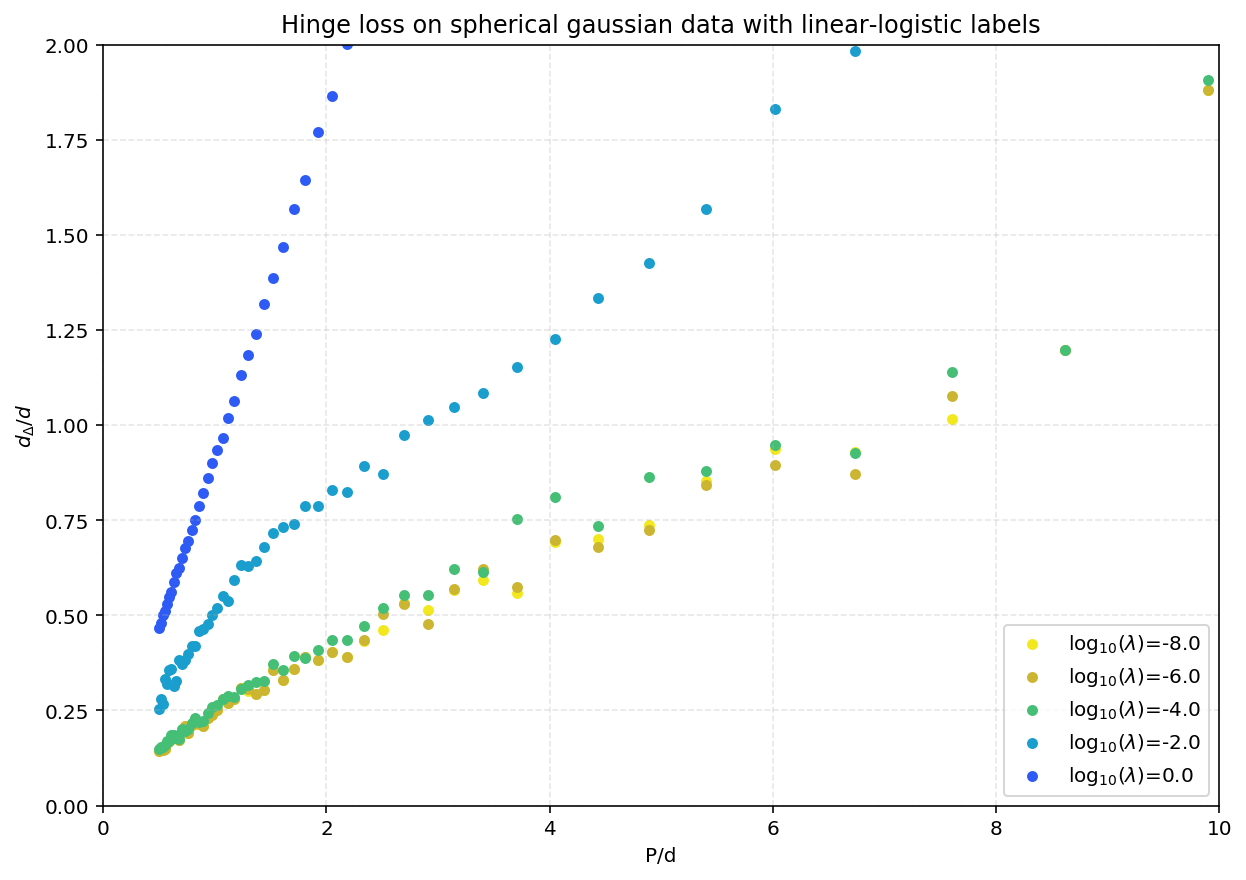

In [276]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/d', 'd_del/d', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

ax.set_ylabel(r'$d_{\Delta}/d$')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
plt.xlim(0, 10)
plt.ylim(0, 2)


# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

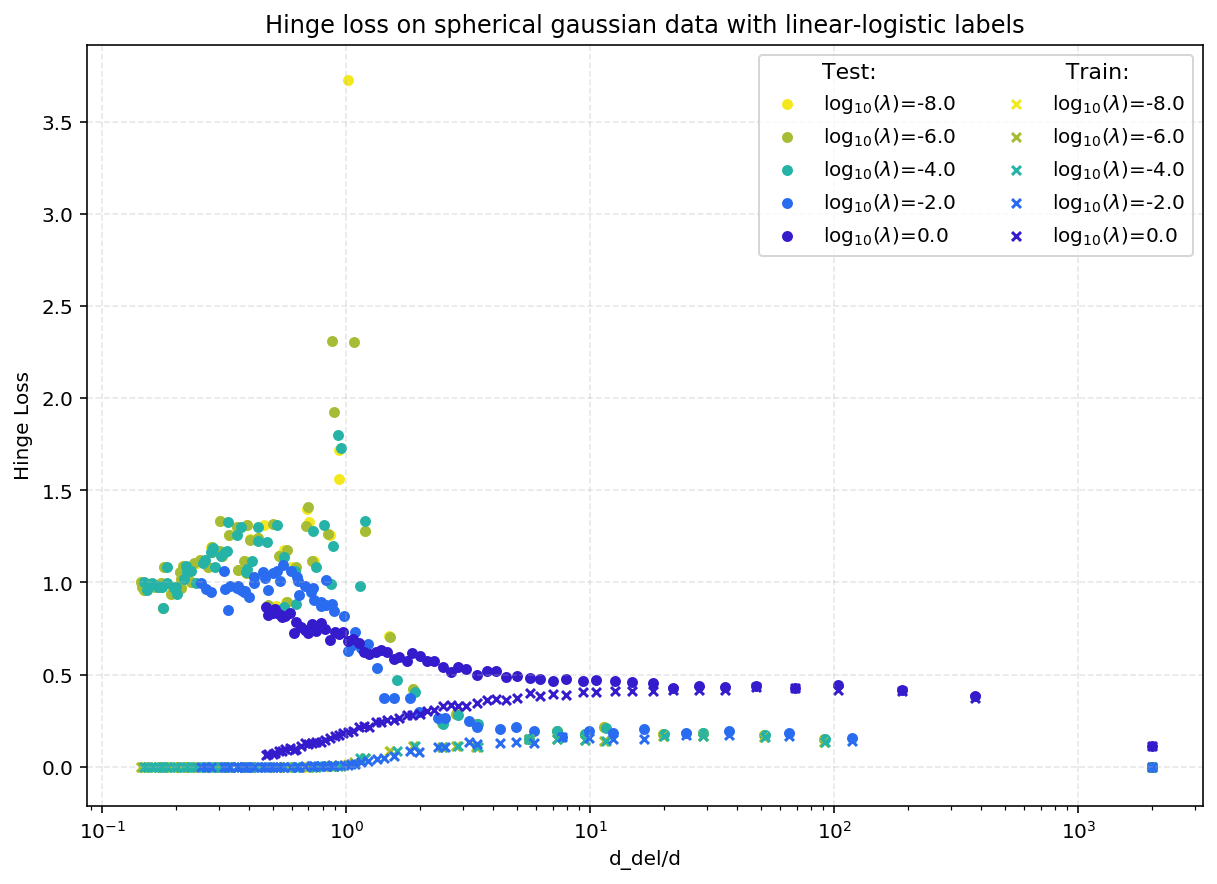

In [336]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('d_del/d', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('d_del/d', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Hinge Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
# ax.set_xlim(0,5)
# ax.set_ylim(-.1,2)
plt.xscale('log')
# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

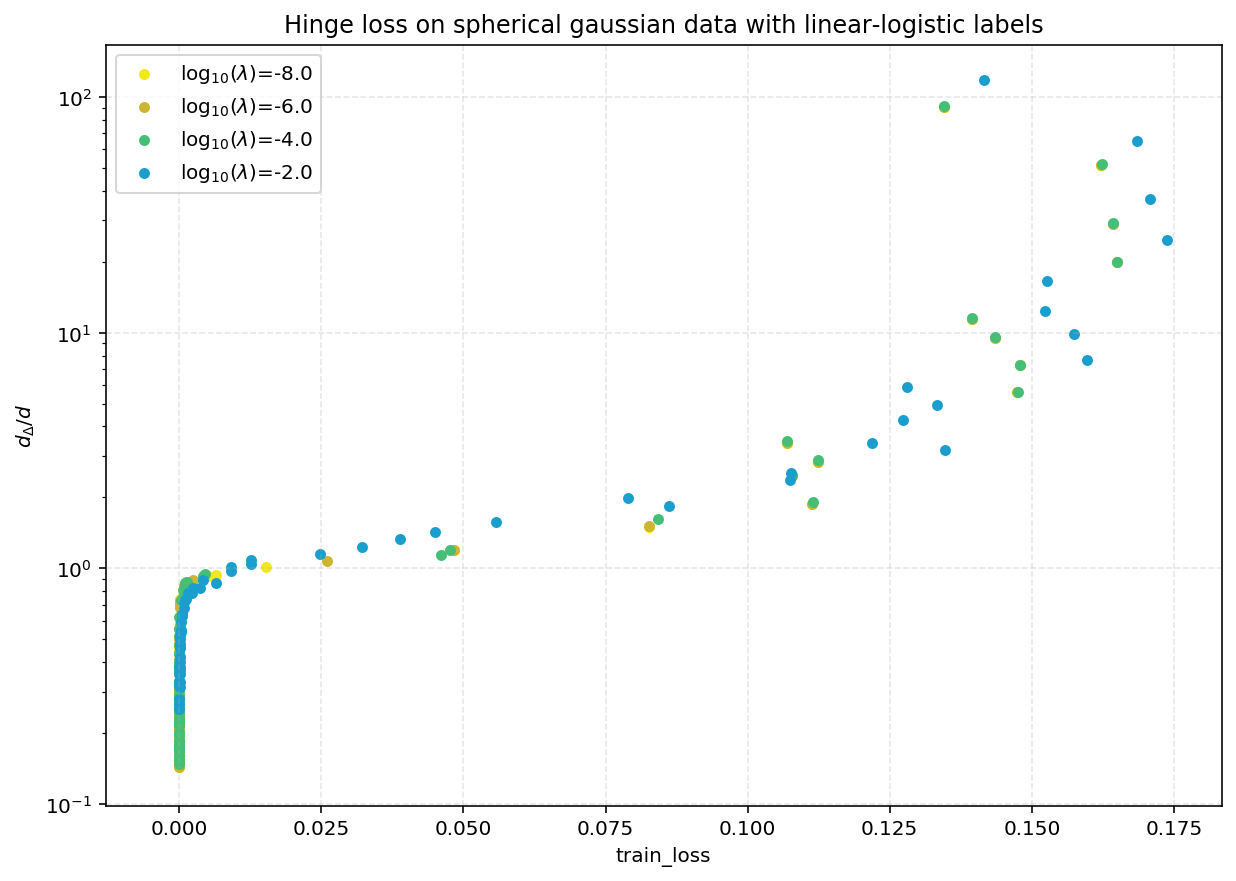

In [51]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    if lamb < 1:
        df.iloc[:-1].plot('train_loss', 'd_del/d', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

ax.set_ylabel(r'$d_{\Delta}/d$')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
plt.yscale('log')
# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

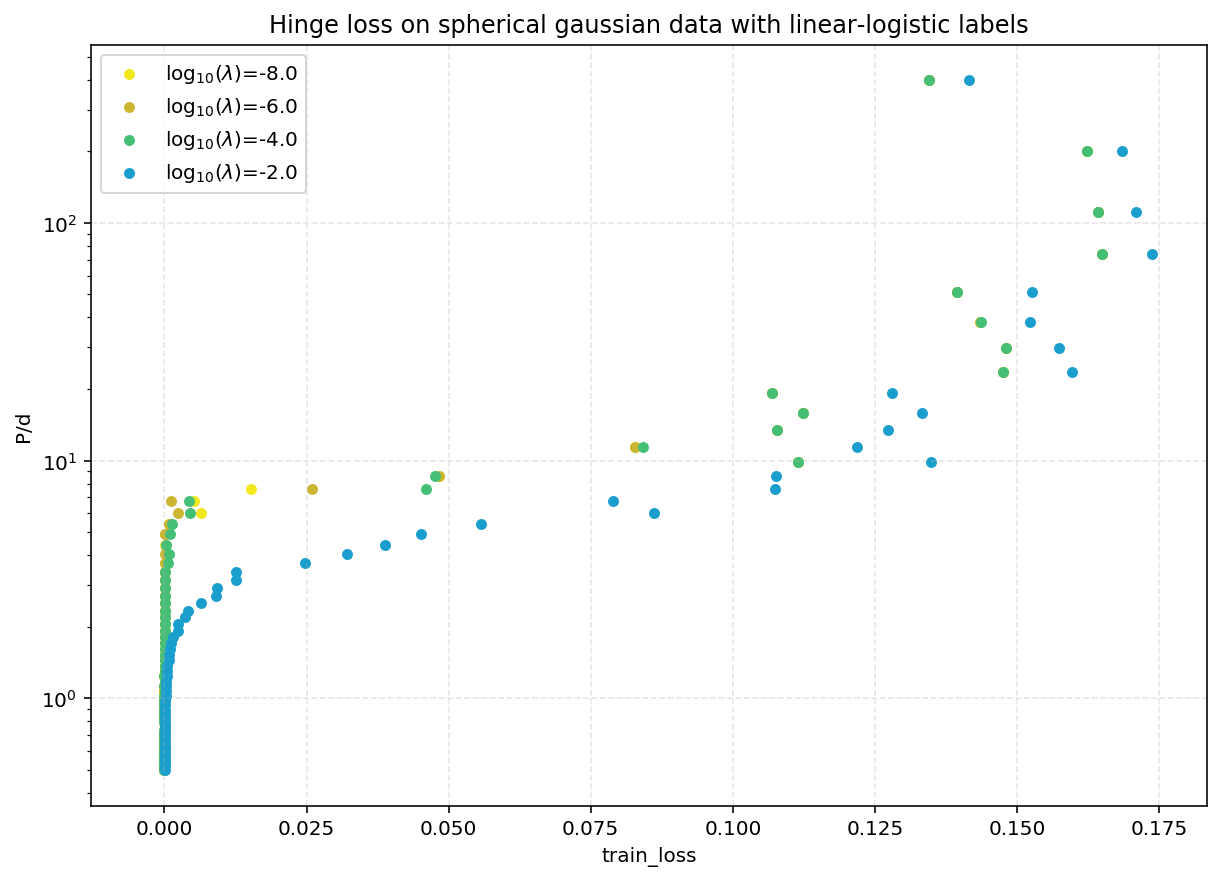

In [54]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    if lamb < 1:
        df.iloc[:-1].plot('train_loss', 'P/d', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
plt.yscale('log')
# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

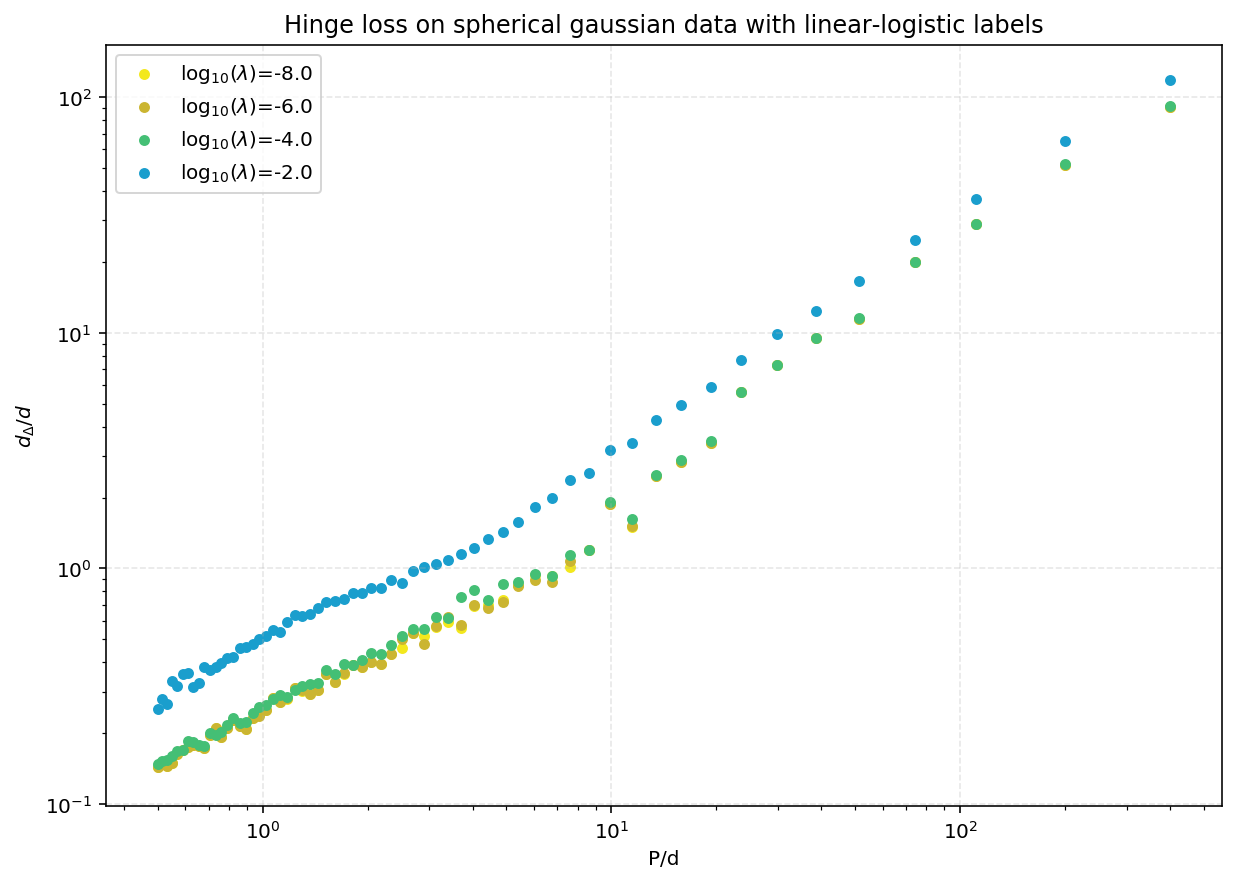

In [56]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    if lamb < 1:
        df.iloc[:-1].plot('P/d', 'd_del/d', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

ax.set_ylabel(r'$d_{\Delta}/d$')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
plt.yscale('log')
plt.xscale('log')

# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

(0, 10)

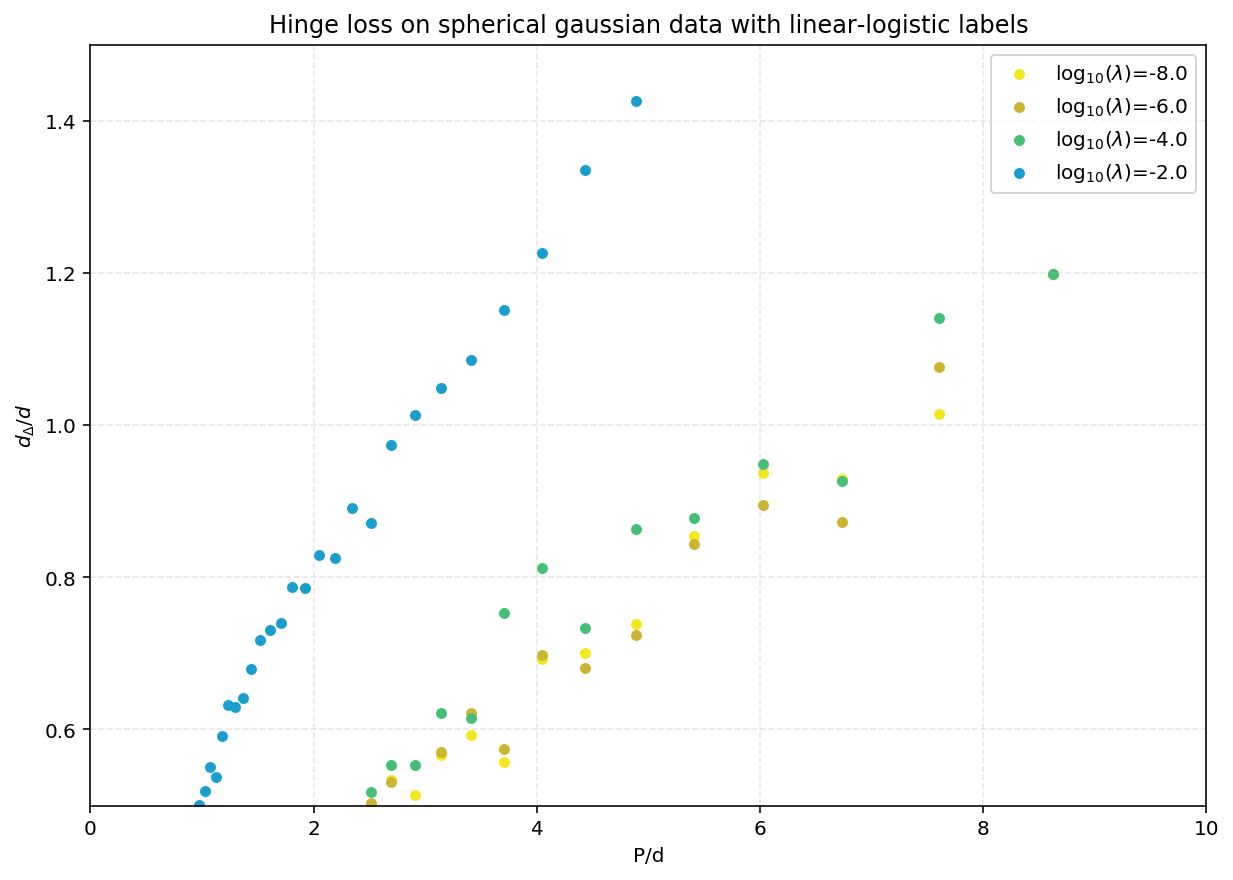

In [63]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    if lamb < 1:
        df.iloc[:-1].plot('P/d', 'd_del/d', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

ax.set_ylabel(r'$d_{\Delta}/d$')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
# plt.xscale('log')
plt.ylim(.5, 1.5)
plt.xlim(0,10)
# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)

Text(0.5, 1.0, 'Hinge loss on spherical gaussian data with linear-logistic labels')

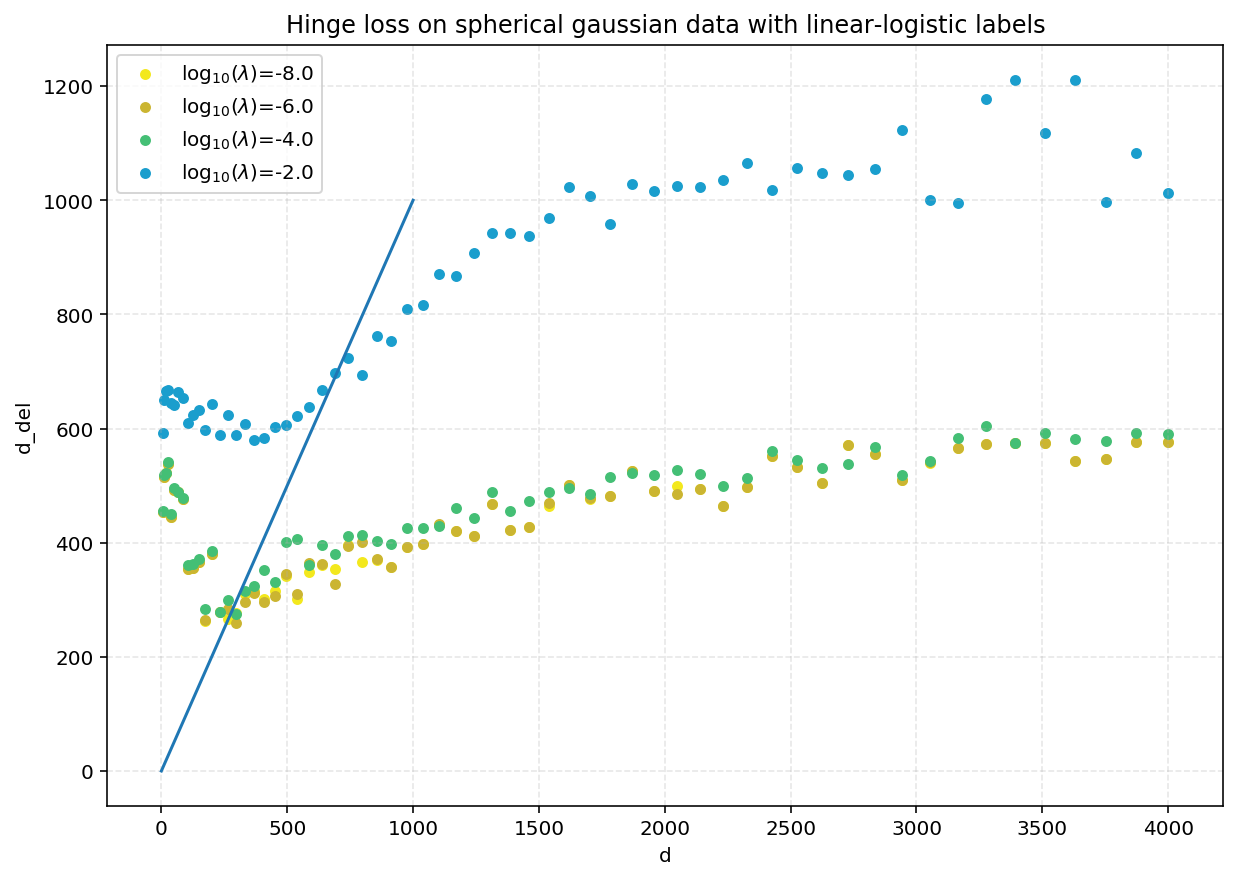

In [81]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    if lamb < 1:
        df.iloc[:-1].plot('d', 'd_del', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors)), kind='scatter')

plt.plot((0,1000), (0,1000))
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on spherical gaussian data with linear-logistic labels')
# fig.savefig('spherical_gaussian_cov_hinge_regularized.png', dpi=300)